In [12]:
import pandas as pd
import numpy as np
import cylouvain
import concurrent.futures
import networkx as nx
from sklearn.preprocessing import normalize
from wavemap_paper.helper_functions import RAND_STATE, set_rand_state
from phylib.io.model import load_model
from umap import umap_ as umap
from matplotlib import cm
from matplotlib import pyplot as plt

# Read the TSV file
cluster_info = pd.read_csv(r'.\test1\20240320_142408_alone_comp_subj_3-1_t6b6_merged.rec\phy\cluster_info.tsv', sep='\t')

good_clusters = np.intersect1d(
    cluster_info['cluster_id'][cluster_info['group'] == 'good'],
    cluster_info['cluster_id'][cluster_info['fr'] > 0.5]
)

# Directly specify the path to params.py
params_path = r'.\test1\20240320_142408_alone_comp_subj_3-1_t6b6_merged.rec\phy\params.py'

# Load the TemplateModel
model = load_model(params_path)

In [5]:
def process_cluster(cluster_id):
    waveforms = model.get_cluster_spike_waveforms(cluster_id)[:, :, 0]
    return (cluster_id, waveforms)

# Dictionary to store the results
cluster_waveforms = {}

# Use ThreadPoolExecutor to handle clusters in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_cluster = {executor.submit(process_cluster, cluster_id): cluster_id for cluster_id in good_clusters}
    for future in concurrent.futures.as_completed(future_to_cluster):
        cluster_id, best_channel_waveforms = future.result()
        cluster_waveforms[cluster_id] = best_channel_waveforms

In [6]:
def calculate_snr(waveforms):
    # Calculate the mean waveform across all spikes in a single cluster, ignoring NaNs
    W_bar = np.nanmean(waveforms, axis=0)
    # Calculate the signal amplitude (max - min of the mean waveform), ignoring NaNs
    sig_amp = np.nanmax(W_bar) - np.nanmin(W_bar)
    # Subtract the mean waveform from each spike to get the noise
    noise = waveforms - np.tile(W_bar, (waveforms.shape[0], 1))
    # Calculate the signal-to-noise ratio, ignoring NaNs
    snr = sig_amp / (2 * np.nanstd(noise.flatten()))
    return snr

# Initialize a dictionary to hold the SNR values for each cluster
snr_dict = {}

# Iterate through each unit/spike_cluster in the cluster_waveforms dictionary
for unit, spikes in cluster_waveforms.items():
    if spikes.ndim == 2:
        # Calculate SNR for each cluster's waveforms
        snr = calculate_snr(spikes)
        # Store the SNR value in the dictionary with its corresponding unit
        snr_dict[unit] = snr
    else:
        print(f"Skipping unit {unit} due to unexpected shape: {spikes.shape}")

# Filter and retain only waveforms with SNR >= 3
high_snr_waveforms = {unit: spikes for unit, spikes in cluster_waveforms.items() if snr_dict[unit] >= 3}

# Determine the number of units excluded due to low SNR
excluded_units = len(snr_dict) - len(high_snr_waveforms)

# Print the result
print(f"Number of excluded units due to low SNR: {excluded_units}")

Number of excluded units due to low SNR: 1


In [7]:
mean_waveforms = {}
for key, waveforms in high_snr_waveforms.items():
    # Calculate the mean along the first axis (axis=0) to average all spikes
    mean_waveform = np.mean(waveforms, axis=0)
    mean_waveforms[key] = mean_waveform

# Initialize a list to hold the normalized waveforms and a mapping list for cluster IDs
normWFs_list = []
cluster_id_list = []

for cluster_id, waveform in mean_waveforms.items():
    # Mean subtraction
    mean_subtracted_waveform = waveform - np.mean(waveform)
    
    # Normalization: reshape the waveform to have a shape of (1, length of waveform)
    # for compatibility with sklearn's normalize function
    reshaped_waveform = mean_subtracted_waveform.reshape(1, -1)
    
    # Normalize the waveform to have a maximum value of 1
    normalized_waveform = normalize(reshaped_waveform, norm='max')
    
    # Store the normalized waveform (squeeze to remove single-dimensional entries from the shape)
    normWFs_list.append(normalized_waveform.squeeze())
    cluster_id_list.append(cluster_id)

In [8]:
# Convert the list to a 2D numpy array
normWFs_array = np.array(normWFs_list)

set_rand_state(RAND_STATE)

reducer = umap.UMAP(random_state = RAND_STATE, n_neighbors = 15)

mapper = reducer.fit(normWFs_array)

# To locate specific spikes by ID in the UMAP output, use cluster_id_list
umap_results = mapper.embedding_

# Create a DataFrame to map cluster IDs to their UMAP coordinates
umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster_ID'] = cluster_id_list

# Now you can query umap_df to locate specific spikes by their cluster IDs
print(umap_df.head())

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1


       UMAP1     UMAP2  Cluster_ID
0  15.564873 -5.729954         117
1  18.015068 -5.383818         190
2  17.533840 -4.496785          13
3  15.452191 -4.714653         115
4  15.952753 -5.080733           9


In [9]:
G = nx.from_scipy_sparse_array(mapper.graph_)

In [11]:
clustering = cylouvain.best_partition(G, resolution = 2)

clustering_solution = list(clustering.values())

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1


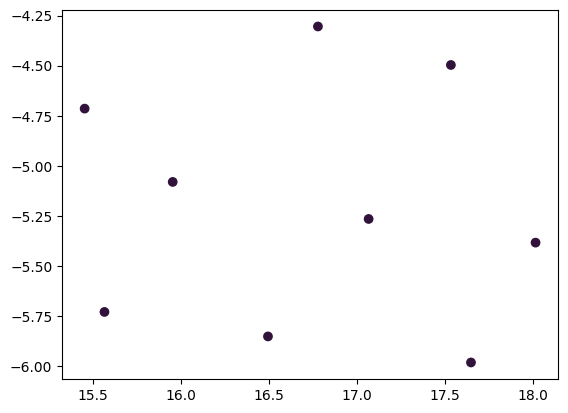

In [15]:
embedding = reducer.fit_transform(normWFs_array)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

umap_df['waveform'] = list(normWFs_array)

umap_df['cluster_id'] = clustering_solution

cmap = plt.get_cmap("turbo")

colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))

umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),

marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

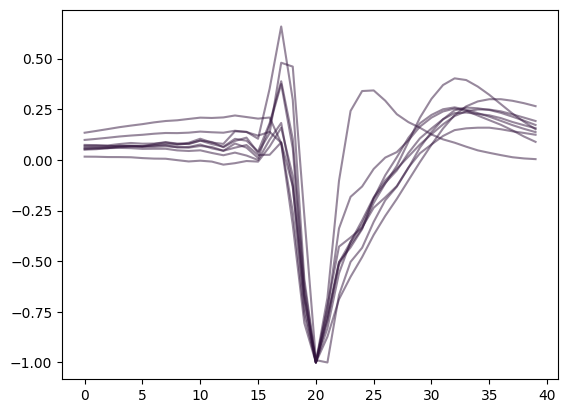

In [17]:
f,arr = plt.subplots(1)

for i,row in enumerate(umap_df['waveform'].tolist()):
    arr.plot(row, c=umap_df['cluster_color'].tolist()[i], alpha=0.5)
plt.show()

In [19]:
umap_df.to_csv('umap_df.csv')